<a href="https://colab.research.google.com/github/msbonus/swhp/blob/master/HP_CHP_PtH_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install iapws

In [0]:
!pip install -q iapws graphviz

all imports

In [0]:
import numpy as np
from enum import IntEnum, auto
from iapws import iapws97
from graphviz import Digraph

Logger

In [0]:
class LogLevel(IntEnum):
  Non = 0
  Err = auto()
  War = auto()
  Inf = auto()
  Debug = auto()
  Trace = auto()
  Spew = auto()

class SimpleLogger:
  elem = "  "
  
  def __init__(self, loglevel = LogLevel.Inf, ind = ""):
    self.loglevel = loglevel
    self.ind = ind

  def err(self, *msg):
    if self.loglevel >= LogLevel.Err:
      print(self.ind, *msg)

  def war(self, *msg):
    if self.loglevel >= LogLevel.War:
      print(self.ind, *msg)

  def inf(self, *msg):
    if self.loglevel >= LogLevel.Inf:
      print(self.ind, *msg)

  def debug(self, *msg):
    if self.loglevel >= LogLevel.Debug:
      print(self.ind, *msg)

  def trace(self, *msg):
    if self.loglevel >= LogLevel.Trace:
      print(self.ind, *msg)

  def spew(self, *msg):
    if self.loglevel >= LogLevel.Spew:
      print(self.ind, *msg)

  def inc(self):
    self.ind += SimpleLogger.elem
    
  def dec(self):
    self.ind = self.ind[0:-len(SimpleLogger.elem)]

  def reset(self):
    self.ind = ""

SI units

In [0]:
class SI:
  SIpfx = {
      'G': 10**9,
      'M': 10**6,
      'k': 10**3,
      'h': 10**2,
      'da': 10**1,
      '1': 1,
      'd': 10**-1,
      'c': 10**-2,
      'm': 10**-3,
      'u': 10**-6,
    }
  
  # Get multiplier by prefix
  def prefix(pfx):
    return SI.SIpfx.get(pfx)
  
  # Format a number with SI prefix
  def fmt(value):
    for pfx in SI.SIpfx:
      sipow = SI.SIpfx.get(pfx)
      if (np.log10(sipow) % 3 == 0):
        if (pfx == "1"): pfx = ""
        if abs(value) >= sipow: return "%g %s" % (value / sipow, pfx)

In [0]:
def isNone(*vars, strict = False):
  if strict:
    for var in vars:
      if not (var is None): return False
    return True
  else:
    for var in vars:
      if (var is None): return True
    return False
  
def dropNone(*vars):
  ret = list()
  for var in vars:
    if not (var is None): ret.append(var)
  return ret

Water properties

In [0]:
pa = 101325/10**6 #MPa
TK0 = 273.15
p = 1 #MPa

def WaterCp(T):
  return (iapws97._Region1(T, pa))["cp"] * 1000 #J/(kg*K)

def SpecificEnthalpy(T):
  return (iapws97._Region1(T, p))["h"] * 1000 #J/(kg)

def WaterDensity(T):
  return 1/iapws97._Region1(T, pa)["v"] #kg/m3

Definition of Class "Heat-transfer fluid"

In [0]:
class HTF:
  def __init__(self, temperature = None, massflow = None, type = 'water'):
    self.temperature = temperature
    self.massflow = massflow
    self.type = type.lower()

  # Temperature is stored in Kelvin, but we are printing Celsius
  def __str__(self, short = False):
    if (short):
      return '%g °C, %g kg/s' % (self.temperature - TK0, self.massflow)
    else:
      return '%s at %g °C, %g kg/s' % (self.type, self.temperature - TK0, self.massflow)
  
  def __eq__(self, other):
    return ((self.type == other.type) and
           (self.temperature == other.temperature) and
           (self.massflow == other.massflow))
  
  def __gt__(self, other):
    return ((self.type == other.type) and
           (not isNone(self.temperature, other.temperature) and (self.temperature > other.temperature)) or
           (not isNone(self.massflow, other.massflow) and (self.massflow > other.massflow)))
  
  def __lt__(self, other):
    return ((self.type == other.type) and
           (not isNone(self.temperature, other.temperature) and (self.temperature < other.temperature)) or
           (not isNone(self.massflow, other.massflow) and (self.massflow < other.massflow)))
  
  def __add__(self, other):
    if isNone(self.temperature, self.massflow, strict = True):
      return HTF(other.temperature, other.massflow)
    elif isNone(other.temperature, other.massflow, strict = True):
      return HTF(self.temperature, self.massflow)
    else:
      log.inf("Mixing", self, "with", other)
      temperature = (self.temperature * self.massflow +
                        other.temperature * other.massflow) / (self.massflow + other.massflow)
      massflow = self.massflow + other.massflow
      htfout = HTF(temperature, massflow)
      log.inf(" ->", htfout)
      return htfout
  
  def __sub__(self, other):
    if (self.temperature != other.temperature):
      raise ValueError("temperatures should match to subtract the flows")
    return HTF(self.temperature, self.massflow - other.massflow)
  
  def min(self, other):
    return HTF(min(dropNone(self.temperature, other.temperature)), min(dropNone(self.massflow, other.massflow)))
  
  def max(self, other):
    return HTF(max(dropNone(self.temperature, other.temperature)), max(dropNone(self.massflow, other.massflow)))
  
  def getCp(self):
    if self.type == 'water':
      return(WaterCp(self.temperature))
    else:
      return 0
    
  def getDens(self):
    if self.type == 'water':
      return(WaterDensity(self.temperature))
    else:
      return 0

Environment

In [0]:
class Environment:
  def __init__(self):
    self.airTemp = 0
    self.waterIn = HTF()
    self.waterOut = HTF()

Definition of Class "Efficiency"

In [0]:
class Efficiency:
  def __init__(self, elecEff = 0, fuelEff = 0):
    self.elecEff = elecEff
    self.fuelEff = fuelEff

Definition of power classes

In [0]:
class PowerType:
  def __init__(self, value = 0, SIprefix = '1'):
    self.value = value * SI.prefix(SIprefix)
    
  def __add__(self, other):
    return type(self)(self.value + other.value)

  def __sub__(self, other):
    return type(self)(self.value - other.value)
  
  def __mul__(self, other):
    return type(self)(self.value * other)
  
  def __str__(self):
    return "%s %sW" % (type(self).__name__, SI.fmt(self.value))

class ElecPower(PowerType):
  pass

class FuelPower(PowerType):
  pass

class Power:
  def __init__(self, *pwr_values):
    self.elecPower = ElecPower()
    self.fuelPower = FuelPower()
    for pwr in pwr_values:
      if type(pwr) is ElecPower:
        self.elecPower += pwr
      elif type(pwr) is FuelPower:
        self.fuelPower += pwr

  def all(self):
    return (self.elecPower.value + self.fuelPower.value)

  # Multiplying Power by efficiency in forward task 
  def __mul__(self, other):
    if type(other) is Efficiency:
      return self.elecPower.value * other.elecEff + self.fuelPower.value * other.fuelEff
    else:
      return 0

  # Dividing Power by Power in reverse task
  # FIXME: what if types are different
  def __truediv__(self, other):
    if type(other) is Power:
      return (self.elecPower.value + self.fuelPower.value) / (other.elecPower.value + other.fuelPower.value)
    elif type(other) is ElecPower:
      return self.elecPower.value / other.value
    elif type(other) is FuelPower:
      return self.fuelPower.value / other.value
    else:
      return 0

  def __add__(self, other):
    return Power(self.elecPower + other.elecPower, self.fuelPower + other.fuelPower)

  def __sub__(self, other):
    return Power(self.elecPower - other.elecPower, self.fuelPower - other.fuelPower)

  def __str__(self):
    val = ""
    for pwr in [self.elecPower, self.fuelPower]:
      if (pwr.value !=0):
        if (val != ""): val += ", "
        val += str(pwr)
    if (val != ""):
      return val
    else:
      return "None"


Definition of energy machines classes


In [0]:
class EItem:
  def __init__(self):
    self.active = True
    
    self.pwr = None
    self.pwr_factor = 1
    self.htfin = None
    self.htfout = None
    
    self.htfin_min = HTF()
    self.htfin_max = HTF()
    
    self.htfout_min = HTF()
    self.htfout_max = HTF()
    
    self.label = None

  # htf input with volume flow limited by htfin_max and htfout_max
  def limit_htfin_massflow(self):
    self.htfin.massflow = min(dropNone(self.htfin.massflow, self.htfin_max.massflow, self.htfout_max.massflow))

  # htf output with volume flow limited by htfin_max and htfout_max
  def limit_htfout(self):
    self.htfout.temperature = min(dropNone(self.htfout.temperature, self.htfout_max.temperature))
    self.htfout.massflow = min(dropNone(self.htfout.massflow, self.htfin_max.massflow, self.htfout_max.massflow))


In [0]:
class EMachine(EItem):
  # input values: Efficiency efficiency
  def __init__(self, efficiency):
    super().__init__()
    
    self.efficiency = efficiency
    self.genEff = 0
    
    self.pwrin_min = 0
    self.pwrin_max = 0

  def gvRepr(self, graph):
    with graph.subgraph(name = 'cluster_' + self.label) as c:
      c.attr('node', shape='record')
      c.attr(label = self.label)
      #c.node(self.label, '{<IN>IN: ' + self.htfin.__str__(short = True) + '|' + str(self.pwr) + '|<OUT>OUT: ' + self.htfout.__str__(short = True) + '}')
      c.node(self.label + '_IN', 'IN: ' + self.htfin.__str__(short = True))
      c.node(self.label + '_OUT', 'OUT: ' + self.htfout.__str__(short = True))
      c.node(self.label, self.label + ': ' + str(self.pwr))
      c.edge(self.label + '_IN', self.label)
      c.edge(self.label, self.label + '_OUT')

  # check parameters
  def check(self):
    if (self.pwr_factor > 1):
      log.trace("pwr_factor > 1")
    elif (self.htfout > self.htfout_max):
      log.trace("self.htfout > self.htfout_max")
    else:
      return True
    return False

  # power generation
  def generate(self):
    # generating electric power from fuel (cogeneration)
    self.pwrgen = Power(ElecPower(self.pwruse.fuelPower.value * self.genEff))

  # power balance
  def balance(self):
    self.pwr = self.pwrgen - self.pwruse

  # defined values: HTF htfin
  # calculated values: Power pwr, HTF htfout
  def forwardtask(self):
    # limit power factor by 100%
    self.pwr_factor = min(self.pwr_factor, 1)
    # power consumption
    self.pwruse = Power(self.pwrin_max * self.pwr_factor)
    
    # htf output is an input...
    self.htfout = HTF() + self.htfin
    # ...plus temperature raise dT
    # dT = P * nu / (m * Cp)
    self.htfout.temperature += self.pwruse * self.efficiency / (self.htfin.massflow * self.htfin.getCp())
    
  # defined values: HTF htfin, HTF htfout
  # calculated values: Power pwrin, Power pwrout
  def reversetask(self):
    # limit output htf temperature and massflow
    self.limit_htfout()
    # power used for heating
    # P = m * Cp * dT
    pwr = (self.htfin.massflow * self.htfin.getCp()) * (self.htfout.temperature - self.htfin.temperature)
    # power consumption and power factor
    self.pwruse = EMachine.splitOutput(pwr, self.efficiency)
    self.pwr_factor = self.pwruse / self.pwrin_max

  # FIXME: double computation
  def splitOutput(pwr, efficiency):
    elecPwr = ElecPower(pwr / efficiency.elecEff) if efficiency.elecEff != 0 else 0
    fuelPwr = FuelPower(pwr / efficiency.fuelEff) if efficiency.fuelEff != 0 else 0
    return Power(elecPwr, fuelPwr)

  def run(self):
    if ((self.pwr_factor == 0) or (self.htfin.massflow == 0)):
      self.active = False

    if (self.active):
      log.inf("Running " + type(self).__name__ + " " + self.label)
      if (not isNone(self.htfin, self.htfout)):
        log.inf("Attempting reverse task")
        self.limit_htfin_massflow()
        self.reversetask()
        if (not self.check()):
          log.inf("Check failed, attempting forward task")
          self.forwardtask()
        self.generate()
        self.balance()
      elif (not isNone(self.htfin)):
        log.inf("Attempting forward task")
        self.limit_htfin_massflow()
        self.forwardtask()
        if (not self.check()):
          log.inf("Check failed, attempting reverse task")
          self.reversetask()
        self.generate()
        self.balance()
      else:
        raise ValueError("not enough input for machine")
      log.inf("Input: " + str(self.htfin) + ", output: " + str(self.htfout))
      log.inf("Energy balance: " + str(self.pwr) + ", power factor:  " + str(self.pwr_factor))
    else:
      log.inf(type(self).__name__ + " " + self.label + " is not active")
      self.pwr = Power()
      self.pwr_factor = 0
      self.htfin = HTF()
      self.htfout = HTF()
  
# Power to heat
class P2H_Machine(EMachine):
  # input values: float elecEff
  def __init__(self, elecEff):
    super().__init__(Efficiency(elecEff = elecEff))
    
# Furnace
class F_Machine(EMachine):
  # input values: float fuelEff
  def __init__(self, fuelEff):
    super().__init__(Efficiency(fuelEff = fuelEff))

# Cogeneration / combined heat and power
class CHP_Machine(EMachine):
  # input values: float fuelEff, float genEff
  def __init__(self, fuelEff, genEff):
    super().__init__(Efficiency(fuelEff = fuelEff))
    self.genEff = genEff
    
# Bypass
class BP_Machine(EMachine):
  def __init__(self):
    super().__init__(Efficiency())
    self.pwrin_max = Power()

In [0]:
# Heat pump
class HP_Machine(EMachine):
  # input values: float elecEff
  def __init__(self, elecEff):
    super().__init__(Efficiency(elecEff = elecEff))
    self.dT = 0
    self.waterIn = HTF()
    self.waterOut = HTF()

  def getCOP(self):
    return self.efficiency.elecEff * (self.htfout.temperature)/(self.htfout.temperature - self.waterIn.temperature)

  # defined values: HTF htfin, HTF waterIn, HTF waterOut
  # calculated values: Power pwr, HTF htfout
  def forwardtask(self):
    # power consumption
    self.pwruse = Power(self.pwrin_max * self.pwr_factor)
    
    # htf output is an input...
    self.htfout = HTF() + self.htfin

    # solving an equation for output temperature
    # P * COP = m * Cp * dT
    ea = self.htfin.massflow * self.htfin.getCp()
    eb = - (self.pwruse * self.efficiency + self.htfin.massflow * self.htfin.getCp() * (self.waterIn.temperature + self.htfin.temperature))
    ec = self.htfin.massflow * self.htfin.getCp() * self.waterIn.temperature * self.htfin.temperature
    eD = eb**2 - 4 * ea * ec
    self.htfout.temperature = (-eb + np.sqrt(eD)) / (2 * ea)
    log.inf("COP:", self.getCOP())

  # defined values: HTF htfin, HTF htfout
  # calculated values: Power pwrin, Power pwrout
  def reversetask(self):
    # limit output htf temperature and massflow
    self.limit_htfout()
    # power used for heating
    # P = m * Cp * dT
    pwr = (self.htfin.massflow * self.htfin.getCp()) * (self.htfout.temperature - self.htfin.temperature)
    # power consumption and power factor
    self.pwruse = Power(ElecPower(pwr / self.getCOP()))
    self.pwr_factor = self.pwruse / self.pwrin_max
    log.inf("COP:", self.getCOP())

Coupling variations

In [0]:
class EConn(EItem):
  def __init__(self, *elements):
    super().__init__()
    
    self.elements = list()
    
    for element in elements:
      self.elements.append(element)

  def run(self):
    log.inf("Running", type(self).__name__, self.label)
    log.inc()
    self.compute()
    log.dec()
    log.inf("Input: " + str(self.htfin) + ", output: " + str(self.htfout))
    log.inf("Energy balance:",self.pwr)
    log.inf()

class ESerial_Conn(EConn):
  def compute(self):
    self.pwr = Power()
    self.limit_htfin_massflow()

    htfin_element = HTF(self.htfin.temperature, 
                       min(dropNone(self.htfin.massflow, self.htfin_max.massflow, self.htfout_max.massflow)))

    for element in self.elements:
      
      element.htfin = HTF() + htfin_element
      
      element.run()

      self.pwr += element.pwr
      htfin_res = htfin_element - element.htfin
      htfin_element = element.htfout + htfin_res

    self.htfout = htfin_element
    
  def gvRepr(self, graph):
    with graph.subgraph(name = 'cluster_' + self.label) as c:
      c.attr('node', shape='box')
      c.node(self.label + '_IN', 'IN: ' + self.htfin.__str__(short = True))
      c.node(self.label + '_OUT', 'OUT: ' + self.htfout.__str__(short = True))
      c.attr(label = self.label)
      for element in self.elements:
        element.gvRepr(c)
      c.edge(self.label + '_IN', self.elements[0].label + '_IN')
      c.edge(self.elements[-1].label + '_OUT', self.label + '_OUT')
      for i in range(len(self.elements) - 1):
        c.edge(self.elements[i].label + '_OUT', self.elements[i+1].label + '_IN')
    
class EParallel_Conn(EConn):
  def compute(self):
    self.htfout = HTF()
    self.pwr = Power()
    
    # pwr input for the first element
    htfin_res = HTF() + self.htfin

    for element in self.elements:
      # htf as input 
      element.htfin = HTF() + htfin_res
      element.run()

      # pwr balance
      self.pwr += element.pwr
      # mix htf output
      self.htfout += element.htfout
      
      # subtract used htf
      htfin_res -= element.htfin
      
      log.inf()

    if (htfin_res.massflow != 0):
      log.inf("Rejected " + str(htfin_res))
      self.htfin -= htfin_res
      
  def gvRepr(self, graph):
    with graph.subgraph(name = 'cluster_' + self.label) as c:
      c.attr('node', shape='box')
      c.node(self.label + '_IN', 'IN: ' + self.htfin.__str__(short = True))
      c.node(self.label + '_OUT', 'OUT: ' + self.htfout.__str__(short = True))
      c.attr(label = self.label)
      for element in self.elements:
        element.gvRepr(c)
        c.edge(self.label + '_IN', element.label + '_IN')
        c.edge(element.label + '_OUT', self.label + '_OUT')

forward task

In [0]:
# Example configuration

envr = Environment()
envr.waterIn = HTF(25 + TK0, 20)

htfin = HTF(70 + TK0, 90)
log = SimpleLogger(LogLevel.Inf)
log.reset()
graph = Digraph()

hp_1 = HP_Machine(0.495)
hp_1.dT = 5
hp_1.waterIn = envr.waterIn
hp_1.waterOut = envr.waterOut
hp_1.label = "HP_1"
hp_1.pwrin_max = ElecPower(6500, "k")
hp_1.htfout_max = HTF(88+TK0, 165.8)

p2h_1 = P2H_Machine(1.0)
p2h_1.label = "P2H_1"
p2h_1.pwrin_max = ElecPower(100, "k")
p2h_1.htfout_max = HTF(999, 10)

p2h_2 = P2H_Machine(1.0)
p2h_2.label = "P2H_2"
p2h_2.pwrin_max = ElecPower(50, "k")
p2h_2.htfout_max = HTF(999, 10)

fur_1 = F_Machine(0.92)
fur_1.label = "FUR_1"
fur_1.pwrin_max = FuelPower(6.52, "M")
fur_1.htfout_max = HTF(999, 57)

fur_2 = F_Machine(0.92)
fur_2.label = "FUR_2"
fur_2.pwrin_max = FuelPower(5.44, "M")
fur_2.htfout_max = HTF(999, 47)

chp_1 = CHP_Machine(0.489, 0.411)
chp_1.label = "CHP_1"
chp_1.pwrin_max = FuelPower(2, "M")
chp_1.htfout_max = HTF(999, 10)

chp_2 = CHP_Machine(0.499, 0.407)
chp_2.label = "CHP_2"
chp_2.pwrin_max = FuelPower(2.42, "M")
chp_2.htfout_max = HTF(999, 10.3)

bps_1 = BP_Machine()
bps_1.label = "BPS_1"
bps_1.htfout_max = HTF(999, 20)

bps_2 = BP_Machine()
bps_2.label = "BPS_2"
bps_2.htfout_max = HTF(999, 97)

stage_1_1 = EParallel_Conn(chp_1, fur_1)
stage_1_1.label = "STAGE_1_1"

stage_1_2i = ESerial_Conn(p2h_1, p2h_2)
stage_1_2i.label = "STAGE_1_2I"
stage_1_2i.htfout_max = HTF(999, 10)
stage_1_2 = EParallel_Conn(chp_2, fur_2, stage_1_2i)
stage_1_2.label = "STAGE_1_2"

system_1 = ESerial_Conn(hp_1, stage_1_1, stage_1_2)
system_1.label = "SYSTEM_1"
system_1.htfin = htfin
system_1.run()

 Running ESerial_Conn SYSTEM_1
   Running HP_Machine HP_1
   Attempting forward task
   COP: 2.2545070735067156
   Check failed, attempting reverse task
   COP: 2.8376071428571428
   Input: water at 70 °C, 90 kg/s, output: water at 88 °C, 90 kg/s
   Energy balance: ElecPower -2.391 MW, power factor:  0.3678458993575295
   Mixing water at 88 °C, 90 kg/s with water at 70 °C, 0 kg/s
    -> water at 88 °C, 90 kg/s
   Running EParallel_Conn STAGE_1_1
     Running CHP_Machine CHP_1
     Attempting forward task
     Input: water at 88 °C, 10 kg/s, output: water at 111.269 °C, 10 kg/s
     Energy balance: ElecPower 822 kW, FuelPower -2 MW, power factor:  1
    
     Running F_Machine FUR_1
     Attempting forward task
     Input: water at 88 °C, 57 kg/s, output: water at 113.038 °C, 57 kg/s
     Energy balance: FuelPower -6.52 MW, power factor:  1
     Mixing water at 111.269 °C, 10 kg/s with water at 113.038 °C, 57 kg/s
      -> water at 112.774 °C, 67 kg/s
    
     Rejected water at 88 °C, 

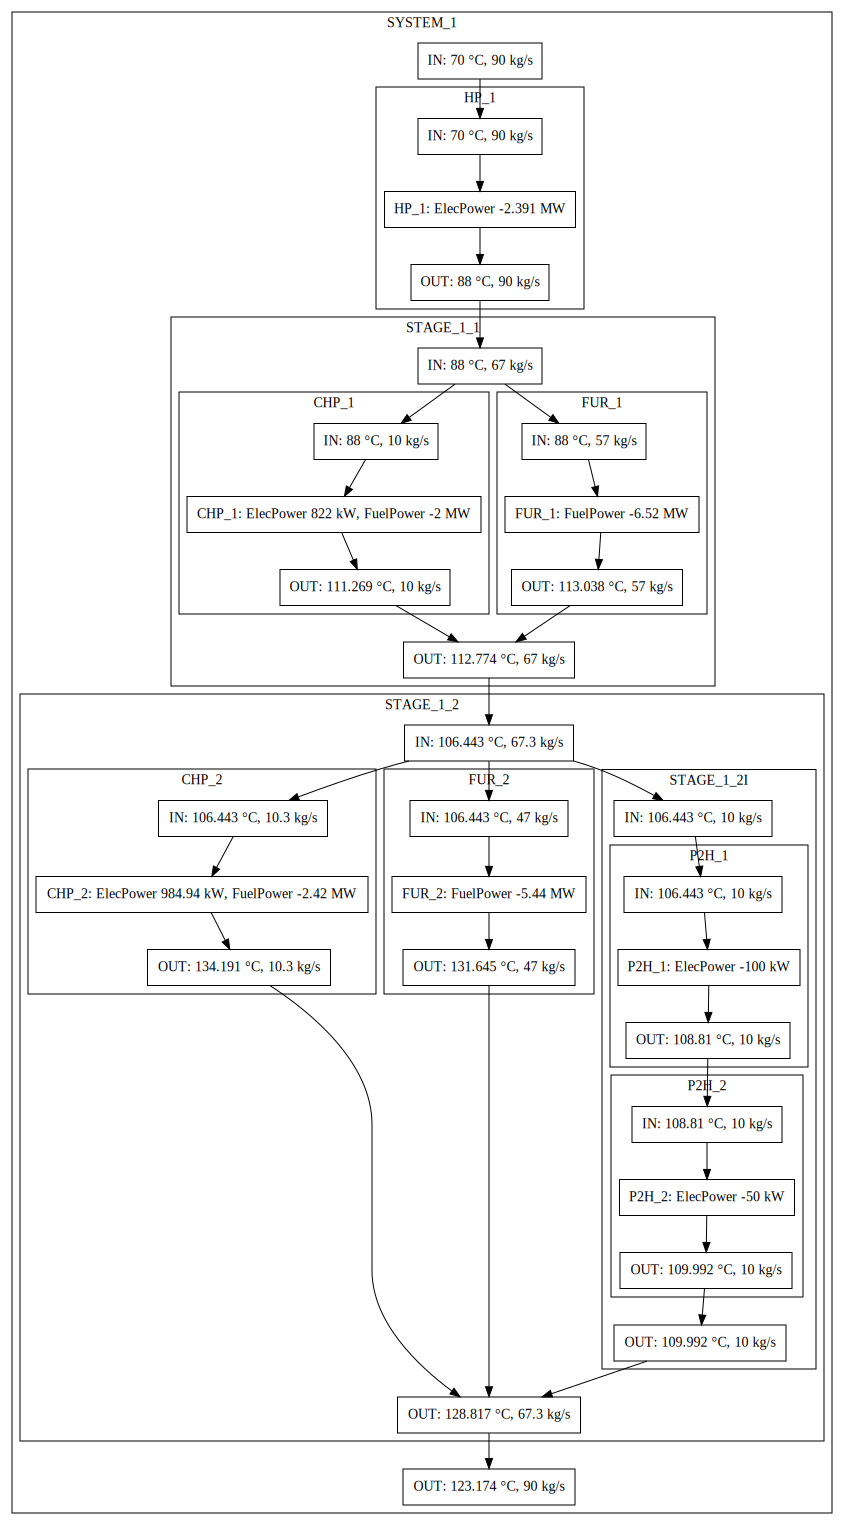

In [0]:
graph = Digraph()
system_1.gvRepr(graph)

graph